In [2]:
%pip install matplotlib pandas

Note: you may need to restart the kernel to use updated packages.


In [1]:
from satellites.utils import get_satellite, get_satellite_passes, get_pass_timeline, get_satellite_passes, get_all_satellites, eph
from skyfield.api import load, wgs84, N, W
from skyfield.units import AngleRate, Distance, Velocity
from datetime import datetime, timedelta
from skyfield.units import Angle
from skyfield.timelib import Time
from skyfield.sgp4lib import EarthSatellite
from skyfield.jpllib import SpiceKernel
from skyfield.toposlib import GeographicPosition
import pytz
import math
from astropy.table import Table
import matplotlib.pyplot as plt

%reload_ext autoreload
%autoreload 2

In [5]:
satellite = get_satellite(25544)
satellite

<EarthSatellite ISS (ZARYA) catalog #25544 epoch 2023-03-12 19:50:43 UTC>

In [6]:
lat, lon = 35.807185453343514, -78.6761513684278

tz = pytz.timezone('America/New_York')
t0 = datetime.now(tz)
t1 = t0 + timedelta(days=10)

t0,t1

(datetime.datetime(2023, 3, 12, 19, 21, 52, 795522, tzinfo=<DstTzInfo 'America/New_York' EDT-1 day, 20:00:00 DST>),
 datetime.datetime(2023, 3, 22, 19, 21, 52, 795522, tzinfo=<DstTzInfo 'America/New_York' EDT-1 day, 20:00:00 DST>))

In [4]:
import cProfile
import pstats
import io
from pstats import SortKey

ob = cProfile.Profile()
ob.enable()

get_satellite_passes([ s.model.satnum for s in get_all_satellites() ], t0, t0 + timedelta(hours=1), lat, lon)

sec = io.StringIO()
sortby = SortKey.CUMULATIVE
ps = pstats.Stats(ob, stream=sec).sort_stats(sortby)
ps.print_stats()
 
print(sec.getvalue())

         13755684 function calls (13409510 primitive calls) in 12.013 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        4    0.000    0.000   12.013    3.003 /Users/stefan/.pyenv/versions/3.10.9/envs/ephem/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3424(run_code)
        4    0.000    0.000   12.013    3.003 {built-in method builtins.exec}
        1    0.043    0.043   12.011   12.011 /Users/stefan/code/stewi2/ephem/satellites/utils.py:76(get_satellite_passes)
    50914    0.061    0.000    6.604    0.000 /Users/stefan/.pyenv/versions/3.10.9/envs/ephem/lib/python3.10/site-packages/skyfield/vectorlib.py:74(at)
     7340    0.073    0.000    6.559    0.001 /Users/stefan/.pyenv/versions/3.10.9/envs/ephem/lib/python3.10/site-packages/skyfield/sgp4lib.py:197(find_events)
     7340    0.007    0.000    5.363    0.001 /Users/stefan/code/stewi2/ephem/satellites/utils.py:99(<listcomp>)
     1433    0.012  

In [14]:
passes = get_satellite_passes([ s.model.satnum for s in get_all_satellites() ], t0, t0 + timedelta(hours=1), lat, lon)
passes

[{'rise': {'timestamp': datetime.datetime(2023, 3, 4, 3, 15, 37, 97728, tzinfo=datetime.timezone.utc),
   'event': 'rise',
   'alt': 30.00106899164509,
   'az': 200.7273761870516,
   'ra': '07h 29m 35.50s',
   'dec': '-21deg 19\' 10.3"',
   'ra_deg': 112.3979157893026,
   'dec_deg': -21.31952808570481,
   'is_sunlit': True,
   'is_dark': True,
   'time_of_day': 'Night'},
  'peak': {'timestamp': datetime.datetime(2023, 3, 4, 3, 28, 2, 436513, tzinfo=datetime.timezone.utc),
   'event': 'peak',
   'alt': 32.42630298777132,
   'az': 180.04512061664803,
   'ra': '08h 58m 42.43s',
   'dec': '-21deg 40\' 40.2"',
   'ra_deg': 134.67680534930645,
   'dec_deg': -21.677837910191673,
   'is_sunlit': True,
   'is_dark': True,
   'time_of_day': 'Night'},
  'set': {'timestamp': datetime.datetime(2023, 3, 4, 3, 40, 28, 326131, tzinfo=datetime.timezone.utc),
   'event': 'set',
   'alt': 29.99978312692887,
   'az': 159.35070502977678,
   'ra': '10h 27m 51.49s',
   'dec': '-21deg 16\' 17.5"',
   'ra_deg'

* Intrinsic brightness (Magnitude) -1.8 (at 1000km distance, 50% illuminated)
* Maximum brightness (Magnitude) -5.7 (at perigee, 100% illuminated)

* https://astronomy.stackexchange.com/a/28765
* https://github.com/skyfielders/python-skyfield/discussions/607

In [129]:
def phase_angle(satellite, coords, eph, t):
    sun = eph['sun']
    earth = eph['earth']
    t = ts.from_datetime(passes[0]['peak']['timestamp'])
    vecObserverSat = (satellite - coords).at(t)
    vecObserverSun = (sun - earth -coords).at(t)
    
    return vecObserverSat.separation_from(vecObserverSun)

In [130]:
ts = load.timescale()
#t = ts.tt_jd(2459752.16671)
t = ts.tt_jd(2459989.98669)
# t = ts.utc(2022,6,21,17,0,0)

coords = wgs84.latlon(35.807185453343514 * N, 78.6761513684278 * W)
sun, earth = eph['sun'], eph['earth']

obs_sun = (earth+coords).at(t).observe(sun).apparent()
obs_sat = (satellite-coords).at(t)

obs_sat.separation_from(obs_sun)


<Angle 73deg 17' 56.2">

In [131]:
phase_angle(satellite, coords, eph, ts.from_datetime(passes[0]['peak']['timestamp']))

<Angle 106deg 11' 03.3">

In [132]:
def estimate_vmag(dist, phase_angle: float, intrinsic_mag: float):
    """
    :param dist: Distance to satellite [km]
    :phase_angle: Angle from sun->satellite->observer [radians]
    :intrinsic_mag: Intrinsic magnitude (at 1000km distance, 50% illuminated)
    """

    return intrinsic_mag \
        + 5.0 * math.log10(dist / 1000.0) \
        + -2.5 * math.log10(math.sin(phase_angle) + (math.pi - phase_angle) * math.cos(phase_angle))

In [133]:
estimate_vmag(485, 78/180*math.pi, -1.8)

-3.695741089906572

In [135]:
passes[0]['peak']

{'timestamp': datetime.datetime(2023, 2, 16, 11, 40, 37, 487350, tzinfo=datetime.timezone.utc),
 'event': 'peak',
 'alt': 75.61578063985407,
 'az': 318.85849990470257,
 'ra': '15h 15m 36.68s',
 'dec': '+46deg 00\' 40.9"',
 'is_sunlit': True,
 'is_dark': True,
 'time_of_day': 'Civil twilight'}

In [198]:
timeline = get_pass_timeline(25544, passes[0]['rise']['timestamp'], passes[0]['set']['timestamp'])

Loaded 7317 satellites
Loaded 7317 satellites
Loaded 7317 satellites
Loaded 7317 satellites
Loaded 7317 satellites
Loaded 7317 satellites
Loaded 7317 satellites
Loaded 7317 satellites
Loaded 7317 satellites
Loaded 7317 satellites
Loaded 7317 satellites
Loaded 7317 satellites
Loaded 7317 satellites


In [196]:
pass_table = Table(rows=timeline)

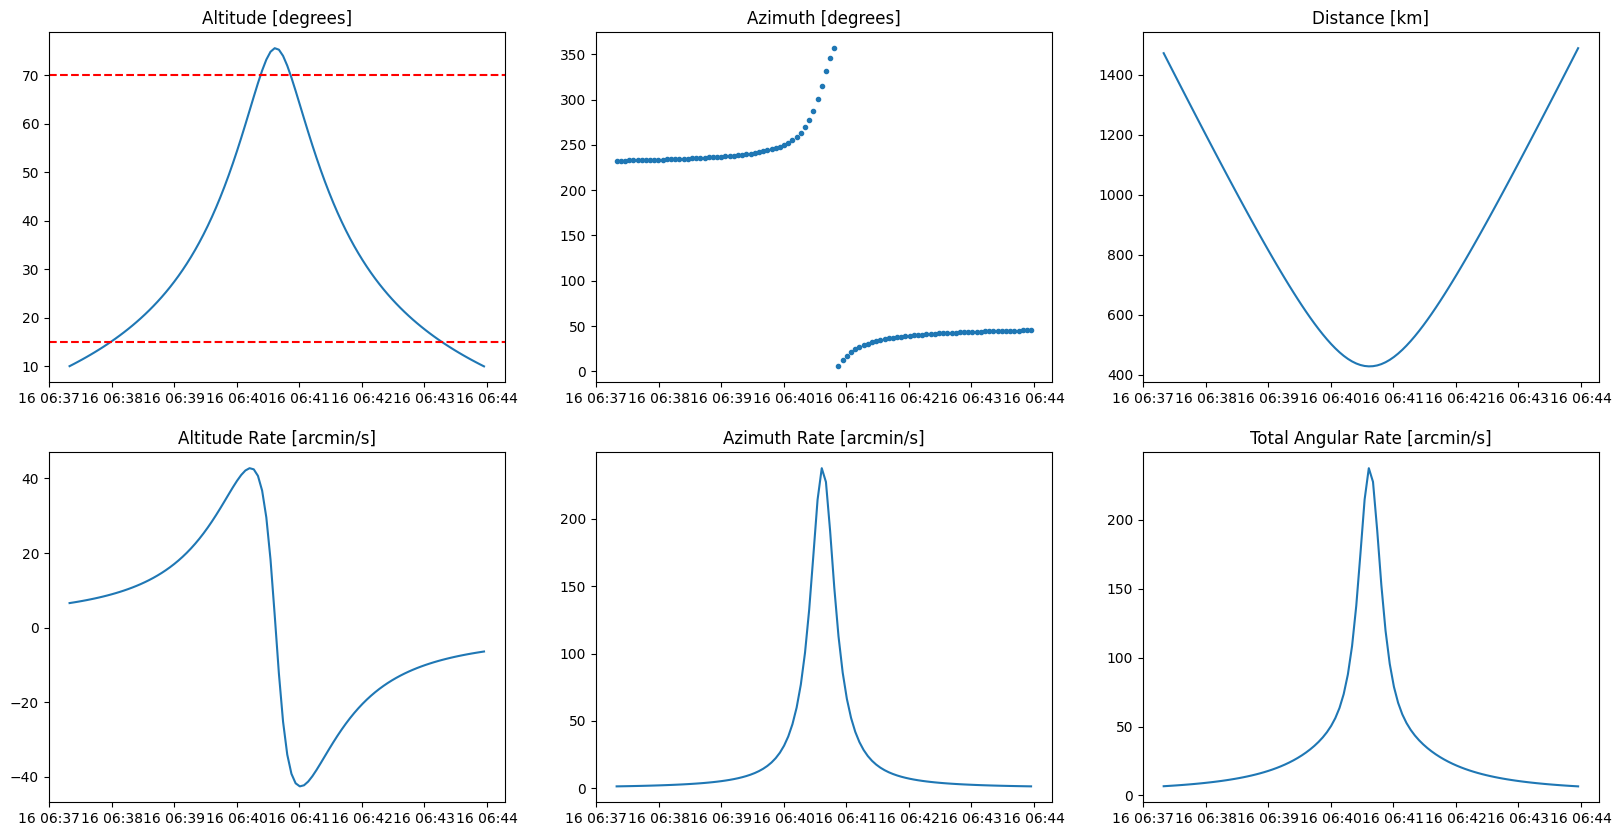

In [197]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20,10))

ax[0][0].plot([r['ts'].astimezone(tz) for r in pass_table if r['is_sunlit']],
              [r['alt'].degrees for r in pass_table if r['is_sunlit']])
ax[0][0].plot([r['ts'].astimezone(tz) for r in pass_table if not r['is_sunlit']],
              [r['alt'].degrees for r in pass_table if not r['is_sunlit']],
              color='orange')
ax[0][0].axhline(y=15, color='red', linestyle='--')
ax[0][0].axhline(y=70, color='red', linestyle='--')
ax[0][0].set_title("Altitude [degrees]")

ax[0][1].scatter([r['ts'].astimezone(tz) for r in pass_table], [az.degrees for az in pass_table['az']], marker='.')
ax[0][1].set_title("Azimuth [degrees]")

ax[0][2].plot([r['ts'].astimezone(tz) for r in pass_table], [dist.km for dist in pass_table['distance']])
ax[0][2].set_title("Distance [km]")

ax[1][0].plot([r['ts'].astimezone(tz) for r in pass_table], [alt_rate.arcminutes.per_second for alt_rate in pass_table['alt_rate']])
ax[1][0].set_title("Altitude Rate [arcmin/s]")

ax[1][1].plot([r['ts'].astimezone(tz) for r in pass_table], [az_rate.arcminutes.per_second for az_rate in pass_table['az_rate']]);
ax[1][1].set_title("Azimuth Rate [arcmin/s]")

#ax[1][2].plot(x, [range_rate.km_per_s for range_rate in pass_table['range_rate']]);
#ax[1][2].set_title("Range Rate [km/s]");

ax[1][2].plot([r['ts'].astimezone(tz) for r in pass_table], [rate.arcminutes.per_second for rate in pass_table['angular_rate']]);
ax[1][2].set_title("Total Angular Rate [arcmin/s]");
